<img src="https://drive.google.com/uc?export=view&id=1x-QAgitB-S5rxGGDqxsJ299ZQTfYtOhb" width=180, align="center"/>

Master's degree in Intelligent Systems

Subject: 11772 - TFM

Year: 2023-2024

Lyes Boudia

## Set up

In [ ]:
# Connect to drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Dataset_Unet/'
%ls -l

# Here the path of the project folder (which is where this file is) is inserted
# into the python path.
import pathlib
import sys

PROJECT_DIR = str(pathlib.Path().resolve())
sys.path.append(PROJECT_DIR)
print(PROJECT_DIR)

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet
total 962661
drwx------ 2 root root      4096 Jul  4 16:27 conc_ref/
-rw------- 1 root root 112674794 Jul  6 17:19 model000.pth
-rw------- 1 root root 153579810 Jul  6 16:32 model123.pth
-rw------- 1 root root 153596130 Jul  5 18:38 model16523.pth
-rw------- 1 root root 151490408 Jul  5 12:00 model_c2.pth
-rw------- 1 root root 151491212 Jul  5 06:25 model_conc.pth
-rw------- 1 root root 262910926 Jun 30 14:58 model.pth
drwx------ 2 root root      4096 Jun 26 09:48 raw-890/
drwx------ 2 root root      4096 Jul  3 13:49 raw_class/
drwx------ 2 root root      4096 Jul  3 13:49 ref_class/
drwx------ 2 root root      4096 Jun 26 09:58 reference-890/
/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet


In [ ]:
!pip install piqa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Import libraries
import os
from imutils import paths
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import math
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from piqa import MS_SSIM
from torchvision.transforms.functional import to_tensor
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
import albumentations as A
import time
import copy
from collections import defaultdict, namedtuple
from torchsummary import summary
import glob
import re
import random
from typing import Tuple, Dict
import random

In [ ]:
# Global variables and parameters
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

# Parameters
NUM_CLASS = 3  # Number of different classes
batch_size = 1  # Batch size

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {str(DEVICE)}")

# Proportion of validation and test dataset sizes
VALID_SIZE = 0.2
TEST_SIZE = 0.1

Using cuda


## First steps

In [ ]:

ds = ''  # relative path from PROJECT_DIR

#Define the paths to the dataset 
RAW_PATH = os.path.join(PROJECT_DIR, ds + 'raw_class')
REF_PATH = os.path.join(PROJECT_DIR, ds + 'ref_class')
CON_PATH = os.path.join(PROJECT_DIR, ds + 'conc_ref')
#show the paths
print(PROJECT_DIR)
print(RAW_PATH)
print(REF_PATH)

/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet
/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class
/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/ref_class


In [ ]:
#we have sorted the list of raw image paths and the list of corresponding reference paths and showing the paths
raw_paths = sorted(list(paths.list_images(RAW_PATH)))
print(raw_paths[:10])
ref_paths = sorted(list(paths.list_images(REF_PATH)))
print(ref_paths[:10])
con_paths = sorted(list(paths.list_images(CON_PATH)))
print(con_paths[:10])

['/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/10139.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/10151.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/101_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/102_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/104_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/105_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/106_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/107_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/108

In [ ]:
# Check if lists are ok

assert len(raw_paths) > 0, "ERROR - Void list!!"

assert len(raw_paths) == len (con_paths), "ERROR - Lists with different length"

for k in range(len(raw_paths)):
    imname = os.path.basename(raw_paths[k]).split('.')[0]
    mkname = os.path.basename(ref_paths[k]).split('.')[0]
    if imname != mkname:
        raise TypeError(f"ERROR - Names inconsistent. raw: ({imname}) reference: {mkname}")

In [ ]:
# Load the image and reference number n
n = 8

# Load the image and reference using PIL
rw = (np.clip(np.asarray(Image.open(raw_paths[n]), dtype=np.float32), 0, 255) / 255.0).astype(np.float32)

rf = (np.clip(np.asarray(Image.open(ref_paths[n]), dtype=np.float32), 0, 255) / 255.0).astype(np.float32)

# Show the image and reference using matplotlib
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(rw)
axs[0].axis('off')
axs[0].set_title(f'Image: {os.path.basename(raw_paths[n])}')
axs[1].imshow(rf)
axs[1].axis('off')
axs[1].set_title(f'Reference: {os.path.basename(ref_paths[n])}')
axs[2].imshow(cn)
axs[2].axis('off')
axs[2].set_title(f'con: {os.path.basename(con_paths[n])}')
plt.show()

plt.show()

## Train, validation and test

In [ ]:
random.seed(42)

num_samples = len(raw_paths)
num_valid = int(num_samples * VALID_SIZE)
num_train = num_samples - num_valid

# Create shuffled indices
random_indices = list(range(num_samples))
random.shuffle(random_indices)

#random_indices = random.sample(range(num_samples), num_samples)
raw_paths = [raw_paths[i] for i in random_indices]
ref_paths = [ref_paths[i] for i in random_indices]
con_paths = [con_paths[i] for i in random_indices]

raw_train_paths = raw_paths[:num_train]
ref_train_paths = ref_paths[:num_train]
con_train_paths = con_paths[:num_train]

print('raw train list ',raw_train_paths)
print('ref train list',ref_train_paths)
print('con train list',con_train_paths)

print()
print()

# Validation paths
raw_valid_paths = raw_paths[num_train:num_train+num_valid]
ref_valid_paths = ref_paths[num_train:num_train+num_valid]
con_valid_paths = con_paths[num_train:num_train+num_valid]
print('raw validation list ',raw_valid_paths)
print('ref validation list ',ref_valid_paths)
print('ref validation list ',con_valid_paths)
print()
print()

raw train list  ['/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/192_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/180_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/493_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/914_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/2787.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/438_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/276_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_Unet/raw_class/432_img_.png', '/content/gdrive/.shortcut-targets-by-id/1dvzRHlgPbUBLqSi2xiiZ_krj-OifiBuk/Dataset_

## The dataset class


# concatenation

In [ ]:
class UnderwaterEnhancementDataset(Dataset):
    def __init__(self, raw_paths, ref_paths, con_paths, transformations=None, min_size=20, num_blocks=7):
        self.raw_paths = raw_paths
        self.ref_paths = ref_paths
        self.con_paths = con_paths
        self.transforms = transformations
        self.min_size = min_size
        self.num_blocks = num_blocks

    def __len__(self):
        return len(self.raw_paths)

    def _calculate_stop_level(self, dimension):
        level = 0
        while dimension > self.min_size:
            if dimension // 2 < self.min_size:
                break  # Stop further downsampling
            dimension = dimension // 2
            level += 1
        return level

    def start_block(self, strideh, stridew):
      # Iterate from the end to find the last occurrence of 2
      for i in range(len(strideh) - 1, -1, -1):
          if strideh[i] == 2 or stridew[i] == 2:
              return i

    def __getitem__(self, idx):
        # Load images
        raw_path = self.raw_paths[idx]
        raw = Image.open(raw_path)
        raw = (np.clip(np.asarray(raw, dtype=np.float32), 0, 255) / 255.0).astype(np.float32)

        ref_path = self.ref_paths[idx]
        ref = Image.open(ref_path)
        ref = (np.clip(np.asarray(ref, dtype=np.float32), 0, 255) / 255.0).astype(np.float32)

        con_path = self.con_paths[idx]
        con = Image.open(con_path)
        con = (np.clip(np.asarray(con, dtype=np.float32), 0, 255) / 255.0).astype(np.float32)

        # Calculate the stopping levels for downsampling
        raw_height, raw_width = raw.shape[:2]
        stop_level_h = self._calculate_stop_level(raw_height)
        stop_level_w = self._calculate_stop_level(raw_width)

        # Determine the stride values for downsampling/upsampling
        stride_h = [2 if i < stop_level_h else 1 for i in range(self.num_blocks)]
        stride_w = [2 if i < stop_level_w else 1 for i in range(self.num_blocks)]

        # Determine the downsampling flag
        downsampling_flag = [True if i < max(stop_level_h, stop_level_w) else False for i in range(self.num_blocks)]
        start_level = self.start_block(stride_h, stride_w)

        # Apply albumentations transforms if any
        if self.transforms:
            transformed = self.transforms(image=raw, mask=ref, conc=con)
            raw, ref, con = transformed['image'], transformed['mask'], transformed['conc']

        # Convert to tensors
        raw_tensor = to_tensor(raw)
        ref_tensor = to_tensor(ref)
        con_tensor = to_tensor(con)

        concatenated_ref = torch.cat((raw_tensor, ref_tensor), dim=0)
        concatenated_pred = torch.cat((raw_tensor, con_tensor), dim=0)

        return (to_tensor(raw), to_tensor(ref), to_tensor(con), stride_h, stride_w, downsampling_flag, start_level, concatenated_pred, concatenated_ref)

In [ ]:
class RandomFixedRotation(A.DualTransform):
    """Albumentations-compatible transform for random fixed rotations."""
    def __init__(self, angles, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.angles = angles

    def apply(self, img, **params):
        angle = params['angle']
        pil_img = Image.fromarray(img)
        rotated_img = pil_img.rotate(angle)
        return np.array(rotated_img)

    def apply_to_mask(self, mask, **params):
        angle = params['angle']
        pil_mask = Image.fromarray(mask)
        rotated_mask = pil_mask.rotate(angle)
        return np.array(rotated_mask)

    def apply_to_pred(self, conc, **params):
        angle = params['angle']
        pil_conc = Image.fromarray(conc)
        rotated_conc = pil_conc.rotate(angle)
        return np.array(rotated_conc)

    def get_params(self):
        return {'angle': random.choice(self.angles)}

In [ ]:
class SynchronizedHorizontalFlip(A.DualTransform):
    """Albumentations-compatible horizontal flip (applied consistently to all images)"""
    def __init__(self, always_apply=False, p=0.5):
        super().__init__(always_apply, p)

    def apply(self, img, **params):
        return img[:, ::-1]  # Horizontal flip for numpy array

    def apply_to_mask(self, mask, **params):
        return self.apply(mask, **params)

    def apply_to_pred(self, conc, **params):
        return self.apply(conc, **params)

    def get_params(self):
        return {}  # No parameters needed for basic flip

In [ ]:
class SynchronizedVerticalFlip(A.DualTransform):
    """Albumentations-compatible vertical flip (applied consistently to all images)"""
    def __init__(self, always_apply=False, p=0.5):
        super().__init__(always_apply, p)

    def apply(self, img, **params):
        return img[::-1, :]  # Vertical flip for numpy array

    def apply_to_mask(self, mask, **params):
        return self.apply(mask, **params)

    def apply_to_pred(self, conc, **params):
        return self.apply(conc, **params)

    def get_params(self):
        return {}  # No parameters needed for basic flip

In [ ]:
transform_train = A.Compose([
    RandomFixedRotation(angles=[0, 90, 180, 270], p=1.0),
    SynchronizedHorizontalFlip(p=0.3),
    SynchronizedVerticalFlip(p=0.3),
])

# For validation (no augmentation)
transform_test = A.Compose([
    # Just normalization if needed
], additional_targets={
    'mask': 'mask',
    'conc': 'conc'
})

Define the datasets

In [ ]:
# Define the three basic datasets
train_set = UnderwaterEnhancementDataset(raw_train_paths,
                       ref_train_paths,
                       con_train_paths,
                       transform_train
                       )

valid_set = UnderwaterEnhancementDataset(raw_valid_paths,
                       ref_valid_paths,
                       con_valid_paths,
                       transform_test)

# test_set = UnderwaterEnhancementDataset(raw_test_paths,
#                       ref_test_paths,
#                                          con_test_paths,
#                       transform_test)

datasets = {'train': train_set, 'valid': valid_set}

And now define the dataloaders

In [ ]:
num_workers = 2
shuffle = True
tbs = 1  # Test batch size
dataloaders = {'train': DataLoader(train_set,
                                   batch_size=batch_size,
                                   shuffle=shuffle,
                                   num_workers=num_workers),
               'valid': DataLoader(valid_set,
                                   batch_size=batch_size,
                                   shuffle=shuffle,
                                   num_workers=num_workers)}

In [ ]:
def to_npimage(tensor_im):
    # From tensor with shape (C x H x W) to numpy with shape (H x W x C)
    return tensor_im.numpy().transpose((1, 2, 0))

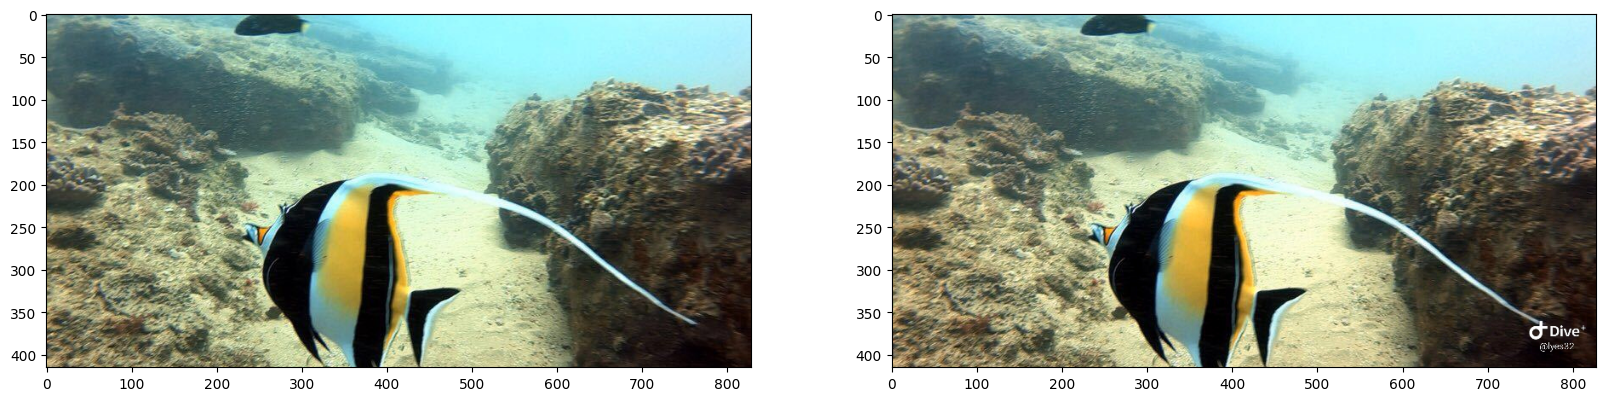

In [ ]:
# Get a batch of training data
inputs, ref, con, stride_h, stride_w, downsampling_flag, start_level, concatenated_pred, concatenated_ref = next(iter(dataloaders['valid']))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Convert tensor image into numpy and display it in the first subplot
raw = to_npimage(inputs[0])
axs[0].imshow(raw)

# Convert tensor mask into numpy and display it in the second subplot
con = to_npimage(con[0])
axs[1].imshow(con)

# Show the figure
plt.show()

In [ ]:
class CustomEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomEncoderBlock, self).__init__()

        self.conv1_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.Leakyrelu1_1 = nn.LeakyReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.Leakyrelu1_2 = nn.LeakyReLU(inplace=True)

        # Downsampling layers
        self.downsample_layers = nn.ModuleDict({
            "2x2": nn.MaxPool2d(kernel_size=2, stride=2),
            "1x2": nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            "2x1": nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        })

        # Residual connection:
        # If in_channels != out_channels, use a 1x1 conv to match dimensions
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        else:
            self.residual_conv = nn.Identity()  # No change needed if channels match

    def forward(self, x, stride_h, stride_w):
        residual = self.residual_conv(x)  # Transform residual if needed

        # Main path
        x = self.Leakyrelu1_1(self.conv1_1(x))
        x = self.Leakyrelu1_2(self.conv1_2(x))

        # Add residual
        x = x + residual  # Residual connection

        # Downsample
        downsample_key = f"{stride_h.item()}x{stride_w.item()}"
        pool = self.downsample_layers[downsample_key](x)

        return x, pool


class CustomDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomDecoderBlock, self).__init__()

        # Define upsampling layers
        self.upconv_layers = nn.ModuleDict({
            "2x2": nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=(2, 2)),
            "1x2": nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=(1, 2)),
            "2x1": nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=(2, 1))
        })

    def forward(self, x, encoder_shape, stride_h, stride_w):
        upconv_key = f"{stride_h.item()}x{stride_w.item()}"
        x = self.upconv_layers[upconv_key](x)

        # Ensure shape matches encoder
        if x.shape[2:] != encoder_shape:
            # Calculate the required padding or cropping
            h, w = x.shape[2], x.shape[3]
            target_h, target_w = encoder_shape

            # Calculate padding or cropping amounts
            pad_h = max(target_h - h, 0)
            pad_w = max(target_w - w, 0)
            crop_h = max(h - target_h, 0)
            crop_w = max(w - target_w, 0)

            # Apply padding if needed
            if pad_h > 0 or pad_w > 0:
                x = F.pad(x, (0, pad_w, 0, pad_h))

            # Apply cropping if needed
            if crop_h > 0 or crop_w > 0:
                x = x[:, :, :target_h, :target_w]

        return x


class UnderwaterUnet(nn.Module):
    def __init__(self, in_channels=6, out_channels=3):
        super(UnderwaterUnet, self).__init__()

        # Encoder blocks
        self.encoders = nn.ModuleDict({
            "enc1": CustomEncoderBlock(in_channels, 32),
            "enc2": CustomEncoderBlock(32, 64),
            "enc3": CustomEncoderBlock(64, 128),
            "enc4": CustomEncoderBlock(128, 256),
            "enc5": CustomEncoderBlock(256, 256),
            "enc6": CustomEncoderBlock(256, 256),
            "enc7": CustomEncoderBlock(256, 256)
        })

        # Decoder blocks
        self.decoders = nn.ModuleDict({
            "dec7": CustomDecoderBlock(256, 256),
            "dec6": CustomDecoderBlock(256, 256),
            "dec5": CustomDecoderBlock(256, 256),
            "dec4": CustomDecoderBlock(256, 128),
            "dec3": CustomDecoderBlock(128, 64),
            "dec2": CustomDecoderBlock(64, 32),
            "dec1": CustomDecoderBlock(32, 32)
        })

        # Decoder convolution blocks
        self.dec_convs = nn.ModuleDict({
            "conv7": self._triple_conv(256 + 256, 256),  # dec7
            "conv6": self._triple_conv(256 + 256, 256),    # dec6
            "conv5": self._triple_conv(256 + 256, 256),     # dec5
            "conv4": self._triple_conv(128 + 256, 128),     # dec4
            "conv3": self._triple_conv(64 + 128, 64),       # dec3
            "conv2": self._triple_conv(32 + 64, 32),        # dec2
            "conv1": self._triple_conv(32 + 32, 32)         # dec1
        })

        # Output layer
        self.out = nn.Conv2d(32, out_channels, kernel_size=1)

    def _triple_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x, stride_h, stride_w, start_level):
        # Encoder path
        encoder_outputs = {}
        current = x

        for i in range(start_level + 1):  # Process up to start_level
            enc_key = f"enc{i + 1}"  # enc1, enc2, ..., enc7
            enc, pool = self.encoders[enc_key](current, stride_h[i], stride_w[i])
            encoder_outputs[enc_key] = enc  # Save encoder output for skip connections
            current = pool

        # Decoder path
        for i in range(start_level, -1, -1):  # Process from start_level back to 0
            dec_key = f"dec{i + 1}"  # dec7, dec6, ..., dec1
            conv_key = f"conv{i + 1}"  # conv7, conv6, ..., conv1

            if i == start_level:
                # For the deepest level, the pooled feature map is used
                dec = self.dec_convs[conv_key](torch.cat([
                    self.decoders[dec_key](current, encoder_outputs[f"enc{i + 1}"].shape[2:], stride_h[i], stride_w[i]),
                    encoder_outputs[f"enc{i + 1}"]
                ], dim=1))
            else:
                # For other levels, previous decoder output is used
                dec = self.dec_convs[conv_key](torch.cat([
                    self.decoders[dec_key](dec, encoder_outputs[f"enc{i + 1}"].shape[2:], stride_h[i], stride_w[i]),
                    encoder_outputs[f"enc{i + 1}"]
                ], dim=1))

            current = dec

        # Output layer
        out = self.out(current)
        out = torch.sigmoid(out)

        return out

In [ ]:
# Hyperparameters
init_learning_rate = 2e-4

# Select model
def select_model(option=1):
    if option == 1:
        arch = "UnderwaterUnet"
        encoder_name = ""
        model = UnderwaterUnet().to(DEVICE)

    else:
        raise ValueError("Invalid option.")

    # AdamW Optimizer (corrected: removed momentum & nesterov)
    optimizer = optim.Adam(
        model.parameters(),
        lr=init_learning_rate
    )

    # Cosine Annealing LR Scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(
          optimizer,
          mode='min',
          factor=0.5,
          patience=16,
          min_lr=1e-6,
          threshold=1e-4
      )

    return model, arch, encoder_name, optimizer, scheduler

In [ ]:
###############################################################################
# Function: save_tr_model
###############################################################################

def save_tr_model(model, optimizer, scheduler, training_log,
                  filename='model_c2.pth', *args, **kwargs):
    model.to(DEVICE)
    custom_dict = {'model_state_dict': model.state_dict(),
                   'opt_state_dict': optimizer.state_dict(),
                   'sche_state_dict': scheduler.state_dict(),
                   'training_log': training_log,
                   'time': time.localtime()}

    torch.save(custom_dict, filename)
    model.to(DEVICE)

In [ ]:
# Initialize MS-SSIM loss
msssim_loss_fn = MS_SSIM().to(DEVICE)
def loss_fcn(pred, target, metrics, mode='train'):

    pred = pred.contiguous()
    target = target.contiguous()

    # 1. Calculate standard losses (60% total)
    msssim_loss = 1 - msssim_loss_fn(pred, target)
    l1_loss = F.l1_loss(pred, target)

    total_loss = 0.8*msssim_loss + 0.2*l1_loss

    # Update metrics
    metrics[mode + '_msssim_loss'] += msssim_loss.detach().cpu().numpy() * target.size(0)
    metrics[mode + '_l1'] += l1_loss.detach().cpu().numpy() * target.size(0)
    metrics[mode + '_loss'] += total_loss.detach().cpu().numpy() * target.size(0)
    metrics[mode + '_epoch_samples'] += target.size(0)

    return total_loss, metrics

In [ ]:
###############################################################################
# Function: update_metrics
###############################################################################

def update_metrics(metrics):
    # Get the number os samples of train and validation or test
    train_epoch_samples = metrics['train_epoch_samples']
    valid_epoch_samples = metrics['valid_epoch_samples']
    test_epoch_samples = metrics['test_epoch_samples']

    # Delete these data from the metrics dictionary
    metrics.pop('train_epoch_samples')
    metrics.pop('valid_epoch_samples')
    metrics.pop('test_epoch_samples')

    # Calculate the average metrics of all the batches; i.e. the epoch metrics
    for m in metrics.keys():
        if m.startswith('train'):
            metrics[m] /= train_epoch_samples
        elif m.startswith('valid'):
            metrics[m] /= valid_epoch_samples
        elif m.startswith('test'):
            metrics[m] /= test_epoch_samples

    return metrics

In [ ]:
###############################################################################
# Function: print_metrics
###############################################################################

def print_metrics(metrics, minimum=False):
    outputs = []

    if minimum:
        outputs.append("Tr loss: {:.4f} - Val loss: {:.4f} - Time: {:.1f}".format(
            metrics['train_loss'], metrics['valid_loss'], metrics['time']))
    else:
        for m in metrics.keys():
            outputs.append("{}: {:.4f}".format(m, metrics[m]))

    print("Epoch summary: {}".format(" - ".join(outputs)))

In [ ]:
def train_model(model, optimizer, scheduler, loaders, num_epochs=10, checkpoint=None, verbose=0):
    # Load training progress if checkpoint exists
    if checkpoint:
        training_log = checkpoint['training_log']
        train_loss_min = np.min([x['train_loss'] for x in training_log])
        trained_epochs = len(training_log)
        best_state_dict = copy.deepcopy(model.state_dict())
    else:
        training_log = []
        train_loss_min = np.inf
        trained_epochs = 0
        best_state_dict = {}

    # Move model to the correct device
    accumulation_steps = 16
    optimizer.zero_grad()

    # Training loop
    for epoch in range(1 + trained_epochs, 1 + trained_epochs + num_epochs):
        start_time = time.time()
        metrics = defaultdict(float)

        if verbose > 0:
            print(f"\nEpoch {epoch}")
            print("---------")

        # TRAINING PHASE
        model.train()
        total_batches = len(loaders['train'])

        for batch_idx, batch in enumerate(loaders['train']):
            # Unpack the batch correctly
            inputs, ref, con, stride_h, stride_w, downsampling_flag, start_level, concatenated_pred, concatenated_ref = batch

            concatenated_pred = concatenated_pred.to(DEVICE)
            ref = ref.to(DEVICE)
            con = con.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(concatenated_pred, stride_h, stride_w, start_level)
            loss, metrics = loss_fcn(outputs, con, metrics, mode='train')
            (loss / accumulation_steps).backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == total_batches:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            if verbose > 0:
                print(f"Batch {batch_idx + 1}/{total_batches} processed", end='\r', flush=True)

        print()  # Ensure newline after the last batch

        # VALIDATION PHASE
        model.eval()
        with torch.no_grad():
            for batch in loaders['valid']:
                # Unpack validation batch
                inputs, ref, con, stride_h, stride_w, downsampling_flag, start_level, concatenated_pred, concatenated_ref = batch

                concatenated_pred = concatenated_pred.to(DEVICE)
                ref = ref.to(DEVICE)
                con = con.to(DEVICE)

                outputs = model(concatenated_pred, stride_h, stride_w, start_level)
                loss, metrics = loss_fcn(outputs, con, metrics, mode='valid')

        metrics['time'] = time.time() - start_time
        metrics = update_metrics(metrics)

        if verbose > 0:
            print_metrics(metrics, minimum=False)

        training_log.append(metrics)

        # Adjust learning rate
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(metrics['train_loss'])
        else:
            scheduler.step()

        # Save best model
        if metrics['train_loss'] < train_loss_min:
            if verbose > 0:
                print("Saving the best model based on train loss...")
            train_loss_min = metrics['train_loss']
            save_tr_model(model, optimizer, scheduler, training_log)
            best_state_dict = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_state_dict)
    return model, training_log

In [ ]:
def plot_training_log(tr_log):
    # Extract losses from the log
    losses = np.array([[m['train_loss'], m['valid_loss']] for m in tr_log])
    tr_losses, vl_losses = losses[:, 0], losses[:, 1]
    x = range(1, 1 + len(losses))
    tr_max, tr_min = np.max(tr_losses), np.min(tr_losses)
    epoch_min = 1 + np.argmin(vl_losses)
    val_min = np.min(vl_losses)

    # Set up plot
    plt.figure(figsize=(8, 6))  # Better aspect ratio
    plt.title('Training and Validation Loss', fontsize=14)

    # Plot losses
    plt.plot(x, tr_losses, label='Training loss', linewidth=2)
    plt.plot(x, vl_losses, label='Validation loss', linewidth=2)

    # Annotate minimum validation loss
    plt.annotate(
        f'Min Val Loss: {val_min:.4f}',
        xy=(epoch_min, val_min),
        xytext=(round(0.75 * len(tr_losses)), 3*(tr_max - tr_min)/4 + tr_min),
        arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)
    )

    # Styling
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.xlim(0, len(tr_losses))
    plt.grid(False)  # Disable grid for cleaner look
    plt.tight_layout()  # Prevent label clipping
    plt.show()

In [ ]:
# Helper function to show the image, the mask and the predicted mask
def show_compare1(img, mask, pred, classif):
    # plt.style.use("ggplot")
    plt.style.use("classic")
    fig = plt.figure(figsize=(30, 10))
    plt.suptitle('Image, reference and prediction', fontsize=16)

    # Subplot 1 - Image
    ax1 = fig.add_subplot(1, 4, 1)
    ax1.set_title('Image')
    plt.imshow(img)

    # Subplot 2 - Mask
    ax1 = fig.add_subplot(1, 4, 2)
    ax1.set_title('reference')
    plt.imshow(mask)

    # Subplot 3 - Prediction
    ax1 = fig.add_subplot(1, 4, 3)
    ax1.set_title('Prediction')
    plt.imshow(pred)

    # Subplot 4 - Class_Prediction
    ax1 = fig.add_subplot(1, 4, 4)
    ax1.set_title('Prediction_class')
    plt.imshow(classif)

    plt.show()

In [ ]:
# Helper function to show the image, the mask and the predicted mask
def show_compare(img, mask, pred):
    # plt.style.use("ggplot")
    plt.style.use("classic")
    fig = plt.figure(figsize=(30, 15))
    plt.suptitle('Image, reference and prediction', fontsize=16)

    # Subplot 1 - Image
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Image')
    plt.imshow(img)

    # Subplot 2 - Mask
    ax1 = fig.add_subplot(1, 3, 2)
    ax1.set_title('reference')
    plt.imshow(mask)

    # Subplot 3 - Prediction
    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('Prediction')
    plt.imshow(pred)

    plt.show()

In [ ]:
# MODEL OPTIONS

m_option = 1

# Load the model
model, arch, encoder_name, optimizer, scheduler = select_model(m_option)
# Tweak hiperparameters of optimizer and scheduler now if desired

# Check if a saved model is requiered
LOAD_TRAINED = True
FILENAME = 'model_conc.pth'

if LOAD_TRAINED:

    # Load checkpoint (the dict saved by 'save_tr_model')
    checkpoint = torch.load(FILENAME, map_location=DEVICE, weights_only=False)

    # Pass the current model to cpu
    model = model.to('cpu')

    # Load the state_dict of the model
    model.load_state_dict(checkpoint['model_state_dict'])

    # Pass the model to DEVICE
    model = model.to(DEVICE)

    # Load state_dict of the optimizador and scheduler
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    scheduler.load_state_dict(checkpoint['sche_state_dict'])

    # Load the training log
    training_log = checkpoint['training_log']

    # Display data about the model loaded
    tsav = checkpoint['time']
    print('Saved on year: {}, month: {}, day:{}, time: {}:{}'.format(
        tsav.tm_year, tsav.tm_mon, tsav.tm_mday, tsav.tm_hour, tsav.tm_min))

Saved on year: 2025, month: 7, day:5, time: 6:25


In [ ]:
m_option = 1

# Load the model
model, arch, encoder_name, optimizer, scheduler = select_model(m_option)

model = model.to(DEVICE)

In [ ]:
n_epochs = 1
model, training_log = train_model(model=model,
                                  optimizer=optimizer,
                                  scheduler=scheduler,
                                  loaders=dataloaders,
                                  num_epochs=n_epochs,
                                  checkpoint={},
                                  verbose=1)


Epoch 1
---------

Epoch summary: train_msssim_loss: 0.0113 - train_l1: 0.0240 - train_loss: 0.0139 - valid_msssim_loss: 0.0124 - valid_l1: 0.0243 - valid_loss: 0.0148 - time: 143.9501
Saving the best model based on train loss...


## Results

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

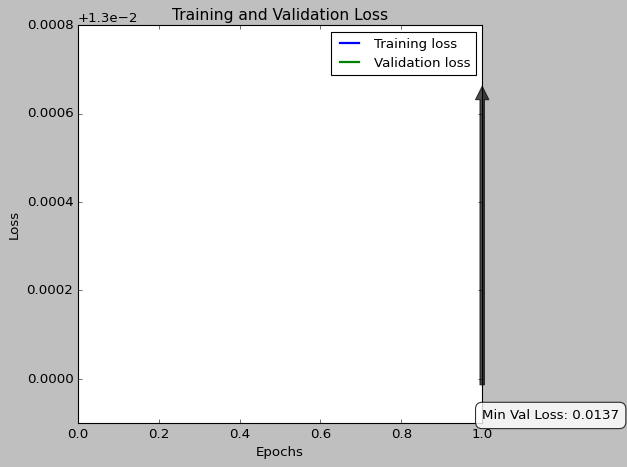

In [ ]:
###############################################################################
# See some results
###############################################################################

# Plot training log
plot_training_log(training_log)

# Get a test batch
model.to('cpu')
model.eval()
inputs, ref, con, stride_h, stride_w, downsampling_flag, start_level, concatenated_pred, concatenated_ref  = next(iter(dataloaders['train']))
# inputs = inputs.to(DEVICE)
# masks = masks.to(DEVICE)

# Predict
pred = model(concatenated_pred, stride_h, stride_w, start_level)

# Leave everything at cpu
concatenated_pred, con, pred = concatenated_pred.cpu(), con.cpu(), pred.cpu()

In [ ]:
# Ensure model is in evaluation mode
model.to('cpu')
model.eval()

msssim_fn = MS_SSIM(n_channels=3).to('cpu')

mse_values = []
psnr_values = []
msssim_values = []
l1_values = []

# Loop through the entire test set
for i, (inputs, ref, con, stride_h, stride_w, downsampling_flag, start_level, concatenated_pred, concatenated_ref) in enumerate(dataloaders['train']):
    # Move data to CPU
    concatenated_pred = concatenated_pred.cpu()
    concatenated_ref = concatenated_ref.cpu()
    ref = ref.cpu()  # Ensure reference is on CPU

    # Predict without gradients
    with torch.no_grad():
        pred = model(concatenated_pred, stride_h, stride_w, start_level)

    # Compute metrics on tensors BEFORE converting to numpy
    msk_tensor = ref[0].unsqueeze(0)  # Shape: [1, C, H, W]
    prd_tensor = pred[0].unsqueeze(0).detach()  # Shape: [1, C, H, W]

    # Compute Mean Squared Error
    mse = F.mse_loss(prd_tensor, msk_tensor).item()
    mse_values.append(mse)

    # Compute PSNR
    psnr = 10 * torch.log10(1 / F.mse_loss(prd_tensor, msk_tensor)).item()
    psnr_values.append(psnr)

    # Compute MS-SSIM
    msssim = msssim_fn(prd_tensor, msk_tensor).item()
    msssim_values.append(msssim)

    # Compute L1 loss
    l1 = F.l1_loss(prd_tensor, msk_tensor).item()
    l1_values.append(l1)

    # Convert to NumPy for visualization (AFTER computing metrics)
    im = to_npimage(inputs[0].cpu())
    msk = to_npimage(con[0].cpu())
    prd = to_npimage(pred[0].detach().cpu())
    ref = to_npimage(ref[0].cpu())

    pred_pil = Image.fromarray((prd * 255).astype(np.uint8))
    pred_pil.save(f"/content/gdrive/MyDrive/results/conc2/pred_{i:04d}.png")

    # Print per-image metrics
    print(f'MSE = {mse:.4f}, '
          f'PSNR = {psnr:.2f} dB, '
          f'MS-SSIM = {msssim:.4f}, '
          f'L1 = {l1:.4f}')

    # Visualize the image, ground truth mask, and prediction
    show_compare1(im, ref, prd, msk)

# Compute averages
avg_mse = np.mean(mse_values)
avg_psnr = np.mean(psnr_values)
avg_msssim = np.mean(msssim_values)
avg_l1 = np.mean(l1_values)

# Print summary
print('\n=== Average Metrics ===')
print(f'MSE:     {avg_mse:.4f}')
print(f'PSNR:    {avg_psnr:.2f} dB')
print(f'MS-SSIM: {avg_msssim:.4f}')
print(f'L1:      {avg_l1:.4f}')